In [145]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import sympy as sp
import HOHWM

In [146]:
K = sp.symbols('K')
x = sp.symbols('x')
t = sp.symbols('t')
u = sp.symbols('u')

K = 1 / 5 * sp.cos(sp.pi * x) * sp.sin(sp.pi * t) * (u**3)

# take the derivative of K with respect to u
dK = sp.diff(K, u)

# lambdify the derivative of K with respect to u
K = sp.lambdify((x, t, u), K, 'numpy')
dK = sp.lambdify((x, t, u), dK, 'numpy')

In [147]:
def Fredholm_1st_iterative_method(
    N, f, K, dK, method="GMRES", tol=1e-8, max_iter=100, verbose=False
):
    def sys_eqs(coefs):
        N = len(coefs) - 1  # Note that coefs includes coef_haar and C1
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        eqs = np.zeros(N + 1)

        coef_haar = coefs[:-1]
        C1 = coefs[-1]

        # coef_haar part
        sigma_LHS = np.zeros(N)
        sigma_RHS = np.zeros(N)
        for i in range(N):
            sigma_LHS += coef_haar[i] * HOHWM.haar_int_1(x, i + 1)
        for k in range(N):
            for i in range(N):
                sigma_RHS += K(
                    x, t[k], C1 + coef_haar[i] * HOHWM.haar_int_1(t[k], i + 1)
                )  # suspicious here
        eqs[:-1] = C1 + sigma_LHS - f(x) - 1 / N * sigma_RHS

        # C1 part
        sigma_C1 = 0
        for k in range(N):
            for i in range(N):
                sigma_C1 += K(
                    0, t[k], C1 + coef_haar[i] * HOHWM.haar_int_1(t[k], i + 1)
                )
        eqs[-1] = C1 - (f(0) + 1 / N * sigma_C1)

        return eqs

    def Jac(coefs):
        N = len(coefs) - 1
        x = HOHWM.collocation(N)
        t = HOHWM.collocation(N)
        jac = np.zeros((N + 1, N + 1))

        coef_haar = coefs[:-1]
        C1 = coefs[-1]

        # coef_haar part
        jac[:-1, :-1] = HOHWM.haar_int_1_mat(x, N)
        jac[-1, :-1] = np.zeros(N)  # pi(0) = 0 for all i

        # C1 part
        jac[:, -1] = np.ones(N + 1)

        x = np.append(x, 0)  # for the last row with C1 equation

        RHS_f_ai = np.zeros((N + 1, N))  # J[:, :-1]
        RHS_f_c1 = np.zeros(N + 1)  # J[:, -1]

        for k in range(N):
            dK_chain2 = np.zeros(N)
            u = C1
            for i in range(N):
                haar_value = HOHWM.haar_int_1(t[k], i + 1)
                u += coef_haar[i] * haar_value
                dK_chain2[i] = haar_value  # check this step for specific K
            dK_chain1 = dK(x, t[k], u)
            RHS_f_ai += np.outer(dK_chain1, dK_chain2)  # dK/dai = dK/du * du/dai
            RHS_f_c1 += dK_chain1

        jac[:, :-1] -= RHS_f_ai / N
        jac[:, -1] -= RHS_f_c1 / N

        return jac

    def newton(coefs, tol=tol, max_iter=max_iter, method=method, verbose=verbose):
        # iter number
        iter = 0

        for i in range(max_iter):
            F = sys_eqs(coefs)
            J = Jac(coefs)

            if method == "LU":
                delta = np.linalg.solve(J, -F)  # LU
            elif method == "CG":
                delta = sla.cg(J, -F)[0]
            elif method == "GMRES":
                delta = sla.gmres(J, -F)[0]
            elif method == "MINRES":
                delta = sla.minres(J, -F)[0]
            else:
                raise NotImplementedError("Only support LU, CG, GMRES, MINRES")

            coefs += delta
            iter += 1

            if np.linalg.norm(delta) < tol:
                break
        if verbose:
            print("iter: ", iter)
            # print("delta: ", delta)
            # print("coefs: ", coefs)

        if iter == max_iter:
            print("Warning: Newton's method does not converge!")

        return coefs

    # get the initial guess
    coefs = np.zeros(N + 1)
    coefs[-1] = f(0)

    # solve the system of equations
    coefs = newton(coefs, tol=tol, max_iter=max_iter, method=method, verbose=verbose)

    # get the coefficients
    coef_haar = coefs[:-1]
    C1 = coefs[-1]

    # define approximated function
    def u_haar_approx_func(x):
        # superposition of the Haar wavelet functions
        approx_func_val = C1
        for k in range(N):
            approx_func_val += coef_haar[k] * HOHWM.haar_int_1(x, k + 1)
        return approx_func_val

    return u_haar_approx_func

In [148]:
f = lambda x: np.sin(np.pi * x)
K = lambda x, t, u: 1 / 5 * np.cos(np.pi * x) * np.sin(np.pi * t) * (u**3)
u_true = lambda x: np.sin(np.pi * x) + 1 / 3 * (20 - np.sqrt(391)) * np.cos(np.pi * x)

K = sp.symbols('K')
x = sp.symbols('x')
t = sp.symbols('t')
u = sp.symbols('u')

K = 1 / 5 * sp.cos(sp.pi * x) * sp.sin(sp.pi * t) * (u**3)

# take the derivative of K with respect to u
dK = sp.diff(K, u)

# lambdify the derivative of K with respect to u
K = sp.lambdify((x, t, u), K, 'numpy')
dK = sp.lambdify((x, t, u), dK, 'numpy')

iter:  14


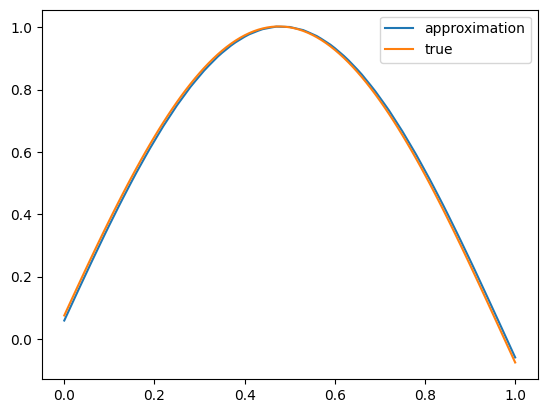

In [150]:
N = 32

# plot the approximated function
u_approx_func = Fredholm_1st_iterative_method(N, f, K, dK, method="LU", verbose=True)
x = np.linspace(0, 1, 101)
y = u_approx_func(x)
plt.plot(x, y, label="approximation")
plt.plot(x, u_true(x), label="true")
plt.legend()
plt.show()

In [153]:
# Compute the error
print_results = True
if print_results is True:
    print("Iterative method for nonlinear Fredholm equation")

    col_size = [1, 2, 4, 8, 16, 32]
    err_local = np.zeros(len(col_size))
    err_global = np.zeros(len(col_size))

    for s in ["1st"]:
        test_x = 0.5  # calculate the error at x = 0.5

        for M in col_size:
            N = 2 * M

            if s == "1st":
                u_approx_func = Fredholm_1st_iterative_method(
                    N, f, K, dK, method="GMRES"
                )
            elif s == "2nd":
                raise NotImplementedError("2nd derivative not implemented yet")
            else:
                raise ValueError("method can only be 1st or 2nd")
            x = np.linspace(0, 1, 101)
            u_true_half = u_true(test_x)
            u_haar_approx_half = u_approx_func(test_x)

            # store the error
            err_local[col_size.index(M)] = abs(u_true_half - u_haar_approx_half)

            # # compute the global error with zero-norm
            # u_true_vec = u_true(x)
            # u_haar_approx_vec = u_approx_func(x)
            # err_global[col_size.index(M)] = np.linalg.norm(
            #     u_true_vec - u_haar_approx_vec)   
            
        # print the error

        print("\n")
        print("Nonlinear Fredholm ({} derivative)".format(s))
        print("For collocation size: M=", col_size)
        print("Error at {}: ".format(test_x), err_local)
        print(
            "Experimental rate of convergence: ",
            np.diff(np.log(err_local)) / np.log(2),
        )
        # print("Global error: ", err_global)
        # print(
        #     "Experimental rate of global convergence: ",
        #     np.diff(np.log(err_global)) / np.log(2),
        # )

Iterative method for nonlinear Fredholm equation


Nonlinear Fredholm (1st derivative)
For collocation size: M= [1, 2, 4, 8, 16, 32]
Error at 0.5:  [0.446 0.077 0.018 0.005 0.054 0.042]
Experimental rate of convergence:  [-2.532 -2.065 -2.016  3.571 -0.377]


check jacobian

In [91]:
def Jac(coefs):
    N = len(coefs) - 1
    x = HOHWM.collocation(N)
    t = HOHWM.collocation(N)
    jac = np.zeros((N + 1, N + 1))

    dK = lambda x, t, u: np.exp(x) * t * u**2  #####

    coef_haar = coefs[:-1]
    C1 = coefs[-1]

    # coef_haar part
    jac[:-1, :-1] = HOHWM.haar_int_1_mat(x, N)
    jac[-1, :-1] = np.zeros(N) # pi(0) = 0 for all i
    
    # C1 part
    jac[:, -1] = np.ones(N + 1)
    
    x = np.append(x, 0) # for the last row with C1 equation
    
    RHS_f_ai = np.zeros((N + 1, N)) # J[:, :-1]
    RHS_f_c1 = np.zeros(N + 1) # J[:, -1]
    
    for k in range(N):
        dK_chain2 = np.zeros(N)
        u = C1
        for i in range(N):
            haar_value = HOHWM.haar_int_1(t[k], i + 1)
            u += coef_haar[i] * haar_value
            dK_chain2[i] = haar_value # check this step for specific K
        dK_chain1 = dK(x, t[k], u) 
        RHS_f_ai += np.outer(dK_chain1, dK_chain2) # dK/dai = dK/du * du/dai
        RHS_f_c1 += dK_chain1
        
    jac[:, :-1] -= RHS_f_ai / N
    jac[:, -1] -= RHS_f_c1 / N
    
    
    
    
    ###### check ######
    print("x", x)
    print("t", t)
    print("For jacobian, xj in in row, ai is in column")
    j = 2
    i = 0
    part1 = HOHWM.haar_int_1(x[j], i + 1) # 0 if x[j] = 0
    part2 = (
        np.exp(x[j])
        * t[0]
        * (
            C1
            + coef_haar[0] * HOHWM.haar_int_1(t[0], 1)
            + coef_haar[1] * HOHWM.haar_int_1(t[0], 2)
        )
        ** 2
        * HOHWM.haar_int_1(t[0], i + 1)
    )
    part3 = (
        np.exp(x[j])
        * t[1]
        * (
            C1
            + coef_haar[0] * HOHWM.haar_int_1(t[1], 1)
            + coef_haar[1] * HOHWM.haar_int_1(t[1], 2)
        )
        ** 2
        * HOHWM.haar_int_1(t[1], i + 1)
    )
    
    print("J[{}, {}] should be".format(j, i), part1 - (part2 + part3)/2)

    part1 = 1
    part2 = (
        np.exp(x[j])
        * t[0]
        * (
            C1
            + coef_haar[0] * HOHWM.haar_int_1(t[0], 1)
            + coef_haar[1] * HOHWM.haar_int_1(t[0], 2)
        )
        ** 2
    )
    part3 = (
        np.exp(x[j])
        * t[1]
        * (
            C1
            + coef_haar[0] * HOHWM.haar_int_1(t[1], 1)
            + coef_haar[1] * HOHWM.haar_int_1(t[1], 2)
        )
        ** 2
    )

    print("J[{}, {}] should be".format(j, N), part1 - (part2 + part3)/2)


    print(jac)

coefs = np.array([1, 2, 3])
jac = Jac(coefs)

x [0.25 0.75 0.  ]
t [0.25 0.75]
For jacobian, xj in in row, ai is in column
J[2, 0] should be -5.51953125
J[0, 2] should be -9.954341836117294
[[ -6.837  -2.489  -9.954]
 [-10.935  -4.265 -17.061]
 [ -5.52   -2.133  -7.531]]
